# VAEを用いた数字合成

TensorFlowチュートリアルのコードを一部利用

# ライブラリのインストール

In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.data import Dataset
from tensorflow.keras.losses import MSE
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Conv2DTranspose, Reshape
from tensorflow.keras.optimizers import Adam

## モデルの設定

In [2]:
class ConvVAE(Model):
    def __init__(self, n_zdim):
        super(ConvVAE, self).__init__()
        self.n_zdim = n_zdim
        self.encoder = self.encoder_model(self.n_zdim)
        self.decoder = self.decoder_model(self.n_zdim)

    # 損失計算・誤差逆伝播関数をオーバーライド
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mu, z_logvar = self.encoder(data) # 入力画像の潜在ベクトルを計算
            z = self.reparameterization(z_mu, z_logvar) # 潜在ベクトルの生成
            reconst = self.decoder(z) # 潜在ベクトルから画像を生成
            """
            損失計算（MATLABチュートリアル参照）
            """
            reconst_loss = tf.reduce_sum(MSE(reconst, data)) # 平均二乗誤差
            KL_loss = -0.5 * tf.reduce_sum(1 + z_logvar - tf.square(z_mu) - tf.exp(z_logvar), 1)
            total_loss = reconst_loss + KL_loss
            
        gradients = tape.gradient(total_loss, self.trainable_variables) # 勾配計算
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables)) # 誤差逆伝播
        return {'loss': total_loss, 'reconst_loss': reconst_loss, 'KL_loss': KL_loss} 

    # エンコーダモデルの定義
    def encoder_model(self, n_zdim):
        encoder_in = Input(shape=(28, 28, 1))
        h = Conv2D(32, (3, 3), strides=(2, 2), activation='relu')(encoder_in)
        h = Conv2D(64, (3, 3), strides=(2, 2), activation='relu')(h)
        h = Flatten()(h)        
        z_mu = Dense(n_zdim, name='z_mu')(h) # 平均
        z_logvar = Dense(n_zdim, name='z_logvar')(h) # 対数分散
        return Model(inputs=encoder_in, outputs=[z_mu, z_logvar]) # 潜在変数の平均・分散

    # デコーダモデルの定義
    def decoder_model(self, n_zdim):
        latent_in = Input(shape=(n_zdim, ))
        h = Dense(7*7*32, activation='relu')(latent_in)
        h = Reshape(target_shape=(7, 7, 32))(h)
        h = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(h)
        h = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(h)
        output = Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', name='output')(h)
        return Model(latent_in, output)
    
    @tf.function
    # 再パラメタライゼーショントリック
    def reparameterization(self, z_mu, z_logvar):
        epsilon = tf.random.normal(shape=tf.shape(z_logvar), mean=0, stddev=1.0) # epsilon生成
        return z_mu + epsilon * tf.exp(0.5 * z_logvar)

    # エンコード処理
    def encode(self, x):
        mean, logvar = self.encoder(x)
        return mean, logvar

    # デコード処理
    def decode(self, z):
        return self.decoder(z)

## テストデータの読み込み

テスト
データの画像のみ利用

In [3]:
(x_train, _), (x_test, y_test) = mnist.load_data() # 訓練データの画像のみ利用
testset = np.expand_dims(np.float32(x_test), -1) / 255. # チャンネルを増やして，float32に変換して正規化

## モデルの作成

モデルの作成(入力:100次元)


In [4]:
#モデルの作成(入力:100次元)
model = ConvVAE(100) 

# テスト

In [5]:
import random
import matplotlib.pyplot as plt

## モデルの読み込み

In [6]:
#model = CondVAE(100)
model_enc = os.path.join('model', 'MNIST_CVAE_ENC')
model_dec = os.path.join('model', 'MNIST_CVAE_DEC')
model.encoder.load_weights(model_enc)
model.decoder.load_weights(model_dec)

## 画像保存用関数の設定

In [7]:
def to_numpy(tftensorimg):
    npy = tftensorimg.numpy().reshape(28, 28) # NumPyへ変換
    max = npy.max()
    min = npy.min()
    npy = (npy - min) / (max - min) * 255. # 濃淡値のレンジを0〜255に広げる
    return np.uint8(npy)


## AEを使った画像生成・合成と画像の表示・保存

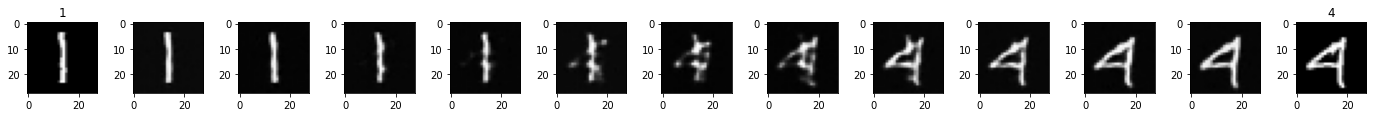

In [8]:
#VAEを使った画像生成・合成
idx = random.randint(0, 9998) # 任意の画像を1つ取り出す
data = testset[idx:idx+2] # 2枚取り出す
z_mu, z_logvar = model.encode(data) # エンコーダに通す

w_mu = []
w_logvar = []
# 0.0から1.0の重みをつけてそれぞれの画像の平均，分散を足し合わせる
for i in range(11):
    w_mu.append((1.0 - i * 0.1) * z_mu[0] + (i * 0.1) * z_mu[1])
    w_logvar.append((1.0 - i * 0.1) * z_logvar[0] + (i * 0.1) * z_logvar[1])
w_mu = tf.Variable(w_mu) # ミニバッチを構成
w_logvar = tf.Variable(w_logvar)
z = model.reparameterization(w_mu, w_logvar) # それぞれの画像の潜在ベクトルを求める
outputs = model.decode(z) # 画像生成

#画像の表示・保存
fig = plt.figure(figsize=(24, 2), dpi=72)
plt.subplots_adjust(wspace=0.5) # 間隔調整
ax = fig.add_subplot(1, 13, 1) # 1行13列の画像
ax.set_title(str(y_test[idx]))
ax.imshow(data[0], cmap='gray')        
for i in range(11):
    img = to_numpy(outputs[i])
    ax = fig.add_subplot(1, 13, i+2) # 1行13列の画像
    ax.imshow(img, cmap='gray')        
ax = fig.add_subplot(1, 13, 13) # 1行13列の画像
ax.imshow(data[1], cmap='gray')        
ax.set_title(str(y_test[idx+1]))
plt.savefig('reconstructed.png')
